## DENSITY (veh/km)

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
# loading data
df1_1 = pd.read_csv('../outputs/counts_per_frame_video_1.csv')
df1_2 = pd.read_csv("../outputs/counts_per_frame_video_2.csv")
df2 = pd.read_csv('../outputs/tracks_per_frame_video_1.csv')

In [101]:
# normalizing frame numbering
df1_1["Frame"] = df1_1["Frame"] - df1_1["Frame"].min()
df1_2["Frame"] = df1_2["Frame"] - df1_2["Frame"].min()

In [102]:
duration_part1_sec = df1_1["Frame"].max() / 60  # video 1 duration in seconds
frame_offset = duration_part1_sec * 60  # offset for video 2 frames

In [103]:
# shifting video 2 frames
df1_2["Frame"] = df1_2["Frame"] + frame_offset + 1

In [104]:
# Merging
df_final = pd.concat([df1_1, df1_2], ignore_index=True).sort_values("Frame")
# Converting frame to minutes
df_final["time_min"] = df_final["Frame"] / 3600  # assuming 60 fps

In [105]:
# --- DENSITY (veh/km) ---
section_length_km = 0.092
df_final["density"] = df_final["Vehicles"] / section_length_km  # 92m road segment
avg_density = df_final["density"].mean()
std_density = df_final["density"].std()

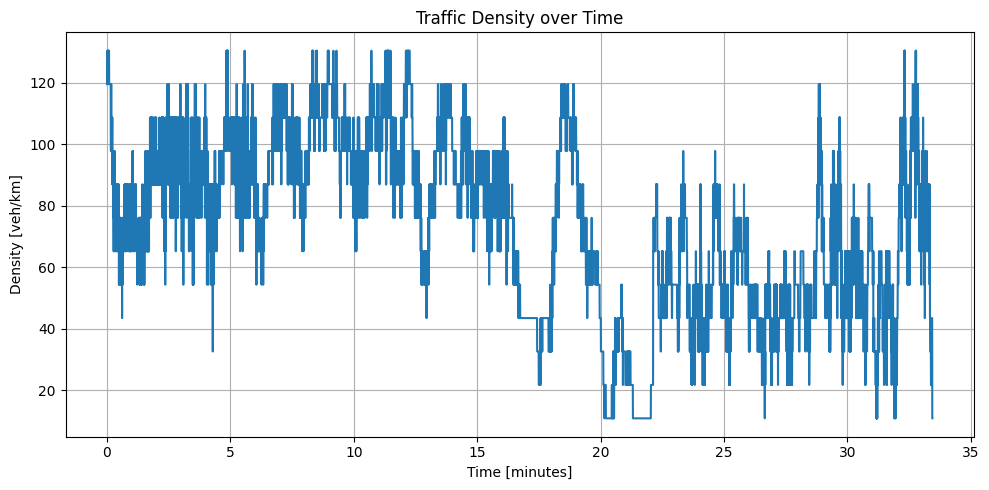

In [106]:
# --- DENSITY VISUALIZATION ---
plt.figure(figsize=(10, 5))
plt.plot(df_final["time_min"], df_final["density"], label="Density (veh/km)")
plt.title("Traffic Density over Time")
plt.xlabel("Time [minutes]")
plt.ylabel("Density [veh/km]")
plt.grid(True)
plt.tight_layout()
plt.show()

## FLOW (veh/h)

In [107]:
df2["time_s"] = df2["frame"] / 60  # assuming 60 fps
flow_veh_per_hour = df2["tracker_id"].nunique() / (df2["time_s"].max() / 3600)

In [108]:
print(flow_veh_per_hour)

1952.4688335655908


## TRAVEL TIME (s) per vehicle

In [80]:
tt = df2.groupby("tracker_id")["time_s"].agg(['min', 'max'])
tt["travel_time_s"] = tt["max"] - tt["min"]
avg_tt = tt["travel_time_s"].mean()
std_tt = tt["travel_time_s"].std()

## SPEED (km/h)

In [109]:
# computing centroid of each vehicle bounding box
df2["x_c"] = (df2["x_min"] + df2["x_max"]) / 2
df2["y_c"] = (df2["y_min"] + df2["y_max"]) / 2

df2 = df2.sort_values(["tracker_id", "frame"])

In [110]:
# determining pixel to meter conversion
pixel_range_y = df2["y_c"].max() - df2["y_c"].min()
section_length_m = 92
scale_m_per_pixel = section_length_m / pixel_range_y
print(f"Scale: {scale_m_per_pixel:.4f} m/pixel")

Scale: 0.0418 m/pixel


In [111]:
# --- For each vehicle, compute travel distance and time ---
vehicle_stats = (
    df2.groupby("tracker_id")
      .agg(y_start=("y_c","first"),
           y_end=("y_c","last"),
           t_start=("time_s","min"),
           t_end=("time_s","max"))
      .reset_index()
)

In [114]:
# --- Compute travel distance in meters (absolute value) ---
vehicle_stats["dist_m"] = abs(vehicle_stats["y_end"] - vehicle_stats["y_start"]) * scale_m_per_pixel


In [116]:
# --- Compute travel time in seconds ---
vehicle_stats["travel_time_s"] = vehicle_stats["t_end"] - vehicle_stats["t_start"]

In [117]:
# --- Compute average speed ---
vehicle_stats["speed_mps"] = vehicle_stats["dist_m"] / vehicle_stats["travel_time_s"]
vehicle_stats["speed_kmh"] = vehicle_stats["speed_mps"] * 3.6

In [119]:
# --- Filter out invalid or too short tracks ---
vehicle_stats = vehicle_stats[vehicle_stats["travel_time_s"] > 1]     # at least 1 s visible
vehicle_stats = vehicle_stats[vehicle_stats["speed_kmh"].between(0.1, 180)]  # realistic range

In [122]:
# --- Compute summary statistics ---
avg_speed = vehicle_stats["speed_kmh"].mean()
std_speed = vehicle_stats["speed_kmh"].std()
avg_travel_time = vehicle_stats["travel_time_s"].mean()

print(f"Average speed: {avg_speed:.1f} km/h")
print(f"Speed std dev: {std_speed:.1f} km/h")
print(f"Average travel time: {avg_travel_time:.1f} s")

Average speed: 4.4 km/h
Speed std dev: 4.9 km/h
Average travel time: 71.1 s


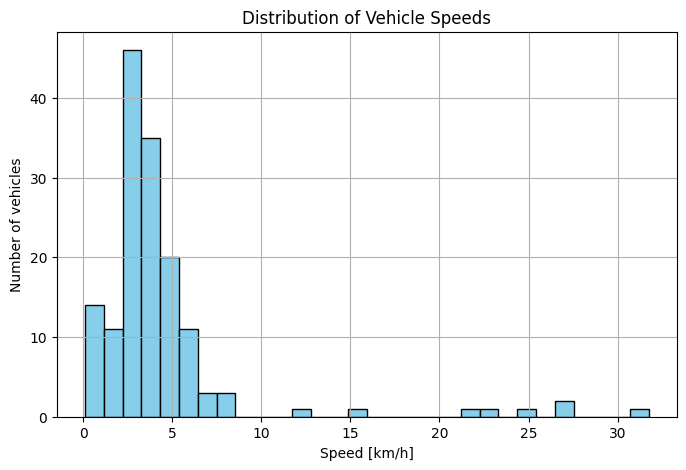

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(vehicle_stats["speed_kmh"], bins=30, color="skyblue", edgecolor="k")
plt.title("Distribution of Vehicle Speeds")
plt.xlabel("Speed [km/h]")
plt.ylabel("Number of vehicles")
plt.grid(True)
plt.show()

## Queue Length (m)

In [133]:
k_crit = 14
section_km = 0.092
df_final["N_queue"] = (((df_final["density"] - k_crit).clip(lower=0)) * section_km).round()

In [135]:
# --- Compute queue length in meters ---
df_final["queue_length_m"] = df_final["N_queue"] * 6.5  # assuming avg vehicle length of 6.5m --> 4.5 m average + 2 m gap

In [136]:
df_final

,Frame,Vehicles,time_min,density,N_queue,queue_length_m
0,0.0,11,0.000000,119.565217,10.0,65.0
1,4.0,11,0.001111,119.565217,10.0,65.0
2,8.0,11,0.002222,119.565217,10.0,65.0
3,12.0,11,0.003333,119.565217,10.0,65.0
4,16.0,11,0.004444,119.565217,10.0,65.0
...,...,...,...,...,...,...
40273,120371.0,1,33.436389,10.869565,0.0,0.0
40274,120373.0,1,33.436944,10.869565,0.0,0.0
40275,120375.0,1,33.437500,10.869565,0.0,0.0
40276,120377.0,1,33.438056,10.869565,0.0,0.0


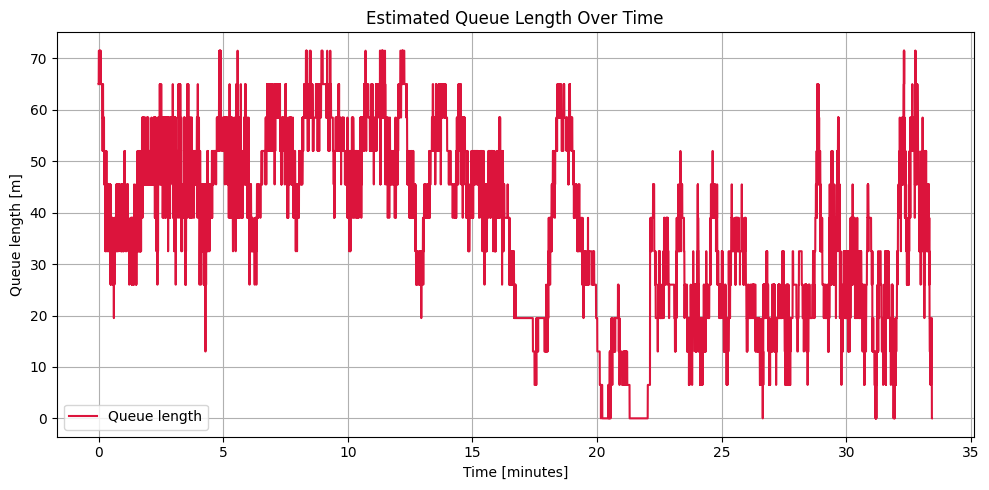

In [137]:
# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(df_final["time_min"], df_final["queue_length_m"], color="crimson", linewidth=1.5, label="Queue length")
plt.title("Estimated Queue Length Over Time")
plt.xlabel("Time [minutes]")
plt.ylabel("Queue length [m]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()